In [11]:
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle


In [12]:
import pandas as pd

df = pd.read_csv("dataset_new.csv")

In [13]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,label
0,0.241644,0.711838,-1.275102e-06,0.365530,0.567069,-0.075918,0.486974,0.416503,-0.139260,0.507687,...,0.639829,0.836040,-0.324446,0.584080,0.820322,-0.295315,0.485812,0.797980,-0.286655,1
1,0.878902,0.964108,-3.172100e-06,0.522812,0.814803,-0.073231,0.263297,0.571140,-0.105153,0.224245,...,0.780831,0.343114,-0.161359,0.756976,0.503610,-0.095260,0.789722,0.551468,-0.021227,2
2,0.696660,0.824854,6.471038e-07,0.762084,0.651498,-0.049508,0.751351,0.429145,-0.072019,0.743372,...,0.383657,0.719273,-0.266930,0.487054,0.725071,-0.280871,0.580974,0.720408,-0.277220,4
3,0.270842,1.009570,-1.404223e-06,0.583175,0.863751,-0.006527,0.738963,0.701614,-0.090739,0.831039,...,0.519982,0.638416,-0.358144,0.578338,0.697263,-0.313303,0.514005,0.711270,-0.277488,5
4,0.194490,0.731501,-1.643752e-06,0.323225,0.585572,-0.096639,0.457148,0.422645,-0.190537,0.480602,...,0.672172,0.855484,-0.379831,0.587808,0.827199,-0.342246,0.460487,0.802710,-0.328644,1


In [14]:
X = df.iloc[:, :-1].values
y = df["label"].values

encoder = LabelEncoder()
y = encoder.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=31)

X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)


with open("label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)


class HandSignDataset(Dataset):

    def __init__(self, X, y):
        self.X = X.view(X.shape[0], 1, 63)
        self.y = y

    def __len__(self):

        return len(self.X)



    def __getitem__(self, idx):

        return self.X[idx], self.y[idx]


train_dataset = HandSignDataset(X_train, y_train)
test_dataset = HandSignDataset(X_test, y_test)



train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)





In [27]:
class HandSignCNN(nn.Module):

    def __init__(self, num_classes):

        super(HandSignCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(128 * 59, 128)  # 59, Conv katmanından gelen boyut
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)



    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [28]:
num_classes = len(encoder.classes_)
model = HandSignCNN(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

In [29]:
num_epochs = 64

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")



# Modeli kaydet

Epoch 1/64, Loss: 1.2464
Epoch 2/64, Loss: 0.7286
Epoch 3/64, Loss: 0.5510
Epoch 4/64, Loss: 0.4526
Epoch 5/64, Loss: 0.3822
Epoch 6/64, Loss: 0.3386
Epoch 7/64, Loss: 0.3043
Epoch 8/64, Loss: 0.2779
Epoch 9/64, Loss: 0.2612
Epoch 10/64, Loss: 0.2428
Epoch 11/64, Loss: 0.2353
Epoch 12/64, Loss: 0.2240
Epoch 13/64, Loss: 0.2153
Epoch 14/64, Loss: 0.2065
Epoch 15/64, Loss: 0.1973
Epoch 16/64, Loss: 0.1949
Epoch 17/64, Loss: 0.1854
Epoch 18/64, Loss: 0.1788
Epoch 19/64, Loss: 0.1727
Epoch 20/64, Loss: 0.1718
Epoch 21/64, Loss: 0.1654
Epoch 22/64, Loss: 0.1604
Epoch 23/64, Loss: 0.1577
Epoch 24/64, Loss: 0.1493
Epoch 25/64, Loss: 0.1458
Epoch 26/64, Loss: 0.1415
Epoch 27/64, Loss: 0.1378
Epoch 28/64, Loss: 0.1347
Epoch 29/64, Loss: 0.1330
Epoch 30/64, Loss: 0.1292
Epoch 31/64, Loss: 0.1261
Epoch 32/64, Loss: 0.1275
Epoch 33/64, Loss: 0.1188
Epoch 34/64, Loss: 0.1157
Epoch 35/64, Loss: 0.1184
Epoch 36/64, Loss: 0.1153
Epoch 37/64, Loss: 0.1110
Epoch 38/64, Loss: 0.1098
Epoch 39/64, Loss: 0.

In [30]:
with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")



Epoch 64/64, Loss: 0.0827


In [31]:
torch.save(model.state_dict(), "hand_sign_cnn14.pth")


Test Loss: 0.0592
Accuracy: 97.95%
Confusion Matrix:
[[258   0   3  10   0]
 [  0 251   0   0   0]
 [  0   1 270   0   2]
 [  4   1   0 260   1]
 [  1   0   3   1 254]]


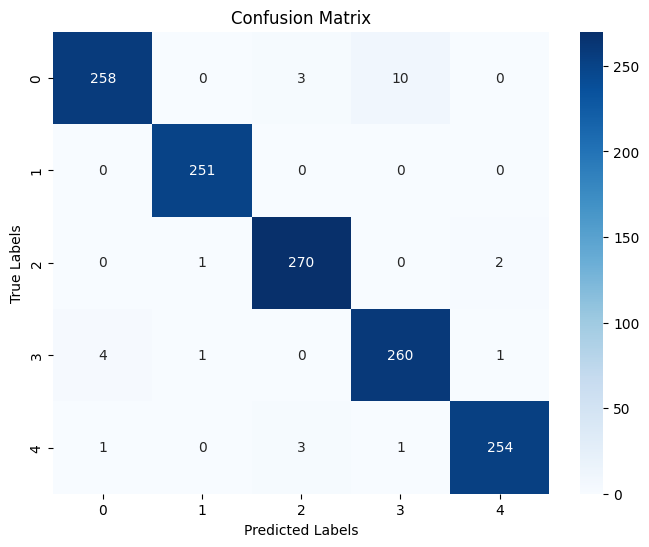

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


model.eval()
criterion = nn.CrossEntropyLoss()

all_preds = []
all_labels = []
test_loss = 0.0

with torch.no_grad():
    for data, targets in test_loader:
        outputs = model(data)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
avg_test_loss = test_loss / len(test_loader)

print(f'Test Loss: {avg_test_loss:.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print(f'Confusion Matrix:\n{cm}')

# Plot confusion matrix (optional but recommended)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()